In [1]:
import pandas as pd
from sklearn.preprocessing import Imputer, OneHotEncoder, Normalizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_val_predict

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam

import pylab as pl
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Загружаем данные
Данные загружены с датасета 2013 года, по которому проходило соревнование от Тинькофф

In [2]:
# Здесь содержатся id клиентов и статус, был ли возвращен займ
customers = pd.read_csv("https://static.tcsbank.ru/documents/olymp/SAMPLE_CUSTOMERS.csv", ';')

# Здесь содержится вся инфромация из кредитных бюро по кредитам клиентов
accounts = pd.read_csv("https://static.tcsbank.ru/documents/olymp/SAMPLE_ACCOUNTS.csv",";",decimal =',')

# Категориальные признаки, будут использоваться далее
cat_features = ['bureau_cd', 'type', 'status', 'relationship', 'pmt_freq']

C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (8,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Препроцессор
Данный клас используется для первичной предобработки датасета. Он наследуется от классов `BaseEstimator` и `TransformerMixin` модуля sklearn. Это позволяет в дальнейшем использовать pipelines для удобной и быстрой обработки данных

In [3]:
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, categorical = True):
        self.categorical = categorical
        
    # мы должны перегрузить дву функции для использования класса
    # fit - считает на основе данных X, после чего экземпляр класса можно использовать для transform.
    # Нам он не нужен в данном случае
    def fit(self, X, y=None):
        return self
    
    # transform изменяет данные X (мы будем передавать туда DataFrame)
    def transform(self, X):
        # Добавим разделение на тип обработки данных. Для категориальных и численных метрик transform будет идти по разному
        if self.categorical == True:
            
            # В метрике pmt_freq обнаружились артефакты, их нужно поправить и привести к числовому значению
            X.loc[X['pmt_freq'] == '1.0', ['pmt_freq']] = 1
            X.loc[X['pmt_freq'] == '2.0', ['pmt_freq']] = 2
            X.loc[X['pmt_freq'] == '3.0', ['pmt_freq']] = 3
            X.loc[X['pmt_freq'] == '4.0', ['pmt_freq']] = 4
            X.loc[X['pmt_freq'] == '5.0', ['pmt_freq']] = 5
            X.loc[X['pmt_freq'] == '6.0', ['pmt_freq']] = 6
            X.loc[X['pmt_freq'] == '7.0', ['pmt_freq']] = 7
            X.loc[X['pmt_freq'] == 'A', ['pmt_freq']] = 8
            X.loc[X['pmt_freq'] == 'B', ['pmt_freq']] = 9
            X['pmt_freq'] = X['pmt_freq'].fillna(7) # Если поле пусто, заполняем значением 7 (Неизвестно)
            X['pmt_freq'] = X['pmt_freq'].astype('int')
            
            # Так же заполняем необходимыми значениями пустые поля
            X['type'] = X['type'].fillna(99)
            X['status'] = X['status'].fillna(0)
            X['relationship'] = X['relationship'].fillna(1)
            
            
            
        if self.categorical == False:
            
            # Для расчета суммы кредита используем валыты и столбец currency датасета. Данные взяты на декабрь 2013 года
            curr_13 = {'USD': 32.72, 'CHF': 36.69, 'EUR': 44.97, 'RUB': 1.0}
            X = pd.merge(X,
                         pd.DataFrame(list(curr_13.values()), index=list(curr_13.keys()), columns=['cr']),
                         left_on='currency',
                         right_index=True,
                         how='left')
            X['credit_limit'] = X.cr * X.credit_limit
            X = X.drop(['currency', 'cr'], axis=1)
            
            # Столбец pmt_string_84m содержит последовательности статусов. Его можно разделить на столбцы отдельных статусов,
            # сосчитав предварительно, сколько определенных статусов получено по каждой выписке кредитного бюро
            vals = list(range(10)) + ['A','X']
            cat_2_num = pd.DataFrame([{'pmt_string_84m_%s' % (str(j)): str(i).count(str(j)) for j in vals} for i in X.pmt_string_84m])
            X = X.join(cat_2_num).drop(['pmt_string_84m'], axis=1)
            
            # В поле final_pmt_date много пробелов. Заполним их данными из дат закрытия кредита.
            X.final_pmt_date[X.final_pmt_date.isnull()] = X.fact_close_date[X.final_pmt_date.isnull()].astype(float)
            X.final_pmt_date = accounts.final_pmt_date.fillna(0)
            
            # fact_close_date изменим. Теперь поле будет обозначать, был ли закрыт кредит. Оно нам понадобится позже.
            X.loc[X['fact_close_date'].isnull() == False, 'fact_close_date'] = 1
            X['fact_close_date'].fillna(0, inplace=True)
            X.fact_close_date = X.fact_close_date.astype('int')
            
            # Нам нужно как-то соединить два датасета: customers и accounts. Т.к. в accounts у нас по каждому кредиту могут быть 
            # дубли из разных кредитных буро (или устаревшая информация), нам надо взять только уникальные и наиболее 
            # полсдение записи по кредитам
            sumtbl = X.pivot_table(['inf_confirm_date'],  ['tcs_customer_id','open_date','final_pmt_date', 'credit_limit'], aggfunc='max')
            X = X.merge(sumtbl, 'left', left_on=['tcs_customer_id','open_date','final_pmt_date', 'credit_limit'],
                          right_index=True, suffixes=('', '_max'))
            
        return X

## One-hot препроцессор
Он будет использоваться для разложения категориальных признаков на one-hot вектор.

In [8]:
class OHTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        ohencoder = OneHotEncoder()
        for item in self.attributes:
            s = pd.Series(X[item].values)
            item_encoded, item_cat = s.factorize()
            item_oh = ohencoder.fit_transform(item_encoded.reshape(-1,1))
            item_df = pd.DataFrame(item_oh.toarray(),
                                   columns=list([item + '_%s_cat' % str(i) for i in range(len(item_cat))]), dtype='int')
            X = X.join(item_df).drop(item, axis=1)
        return X

## Постпроцессор
Его задача - максимально упростить и сжать датасет

In [5]:
class Postprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, customers_df, corr_limit = 0.95):
        self.customers_df = customers_df
        self.corr_limit = corr_limit
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        
        # Оставляем только уникальные и наиболее свежие записи
        X = X[X.inf_confirm_date == X.inf_confirm_date_max].drop_duplicates()
        X = X.groupby(['tcs_customer_id','open_date','final_pmt_date', 'credit_limit']).max().reset_index()
        
        # Удаляем ненужные столбцы
        X = X.drop(['bki_request_date', 'inf_confirm_date', 'pmt_string_start', 'open_date', 'final_pmt_date',
                    'inf_confirm_date_max'], axis=1)
        
        # Заполняем нулями все пустын значения
        X = X.fillna(0)
        
        # Добавляем новый столбец, проссуммировав который в итоге получим кол-во кредитов у клиента
        X['count_cr'] = 1
        
        # Суммируем по клиентам
        X = X.groupby('tcs_customer_id').sum()
        
        # Теперь объединяем 2 датасета, выбираем в итоге только тренировочные данные (только в них есть возможность
        # проверить нашу модель, т.к. в тестовом дате нет факта возврата кредита)
        customers_train = self.customers_df.set_index('tcs_customer_id')
        X = X.join(customers_train)
        X = X[X.sample_type == 'train']
        X = X.drop('sample_type', axis=1)
        
        # Чтобы еще упростить датасет, можно посмотреть корреляцию метрик между собой
        X_corr = X.corr()
        
        # Для начала найдем все метрики, у которых нет корреляции совсем (т.е. скорее всего они заполнены одинаковыми значениями)
        drop_features = [f for f in X_corr if X_corr[f].isnull().values[0]]
        
        # Пробегаемся по всей корреляционной матрице и находим метрики, с корреляцией больше чем с установленным в конструкторе
        # значением
        for i in X_corr.index:
            for j in X_corr.columns:
                if X_corr.loc[i, j] > self.corr_limit and i != j and i not in drop_features and j not in drop_features:
                    drop_features.append(j)
                    print(i + ' ^ ' + j + ' = ' + str(X_corr.loc[i,j]))
        # Удаляем их, т.к. такие метрики малоинформативны            
        X = X.drop(drop_features, axis=1)
        
        return X

## Pipelines
Pipelines позволяют аккуратно и быстро предобработать датасет. У нас он по сути состоит из кастомных препроцессоров, однако в scikit-learn есть множество готовых и полезных трансформеров (одним из них воспользуемся в конце)

In [9]:
all_pipeline = Pipeline([
    ('preprocessor_num', Preprocessor(categorical=False)),
    ('preprocessor_cat', Preprocessor(categorical=True)),
    ('oh_transformer', OHTransformer(cat_features)),
    ('postprocessor', Postprocessor(customers, corr_limit=0.9))
])

In [10]:
prep_dataset = all_pipeline.fit_transform(accounts)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


fact_close_date ^ status_1_cat = 0.9973921193613292
ttl_delq_5_29 ^ ttl_delq_30 = 0.9544572453560792
ttl_delq_5_29 ^ pmt_string_84m_A = 0.9258403168721584
ttl_delq_30_59 ^ pmt_string_84m_2 = 0.9032492484446097
ttl_delq_90_plus ^ pmt_string_84m_5 = 0.9782466731899646
delq_balance ^ max_delq_balance = 0.9869645539821194
type_1_cat ^ relationship_0_cat = 0.9214572705457991
type_1_cat ^ count_cr = 0.920556662626364


In [11]:
# Отделяем датасет от target значений (в нашем случае факт возврата кредита)
train, target = prep_dataset.drop('bad', axis=1), prep_dataset['bad']


In [12]:
# Еще один трансформел scikit-learn. PCA (метод гланых компонент) - позволяет уменьшить размерность пространства метрик, 
# сохранив при этом максимум информации. Является гиперпараметром, т.к. варьируя кол-во новых метрик, можно повысить качество
# итоговой модели (однако чем больше метрик - тем дольше и сложнее будет считаться модель)
pca = PCA(n_components=30)
train_pca = pca.fit_transform(train)

In [13]:
# Разделяем наш датасет на тренировочный (на нем модель будет обучаться), и на тестовый (валидация)
train_data, val_data, train_target, val_target = train_test_split(train_pca, target, test_size = 0.2)

# Random Forest
Пришло время запустить модель. Для начала возьмем RandomForest

In [15]:
# Каждый алгоритм рассмотрим в разрезе гиперпараметров, чтобы найти лучший вариант
rnd_f_120_4_4 = RandomForestClassifier(n_estimators=120, max_depth=4, max_leaf_nodes=4, criterion='entropy')
rnd_f_200_4_4 = RandomForestClassifier(n_estimators=200, max_depth=4, max_leaf_nodes=4, criterion='entropy')
rnd_f_120_8_4 = RandomForestClassifier(n_estimators=120, max_depth=8, max_leaf_nodes=4, criterion='entropy')
rnd_f_200_8_4 = RandomForestClassifier(n_estimators=200, max_depth=8, max_leaf_nodes=4, criterion='entropy')
rnd_f_120_8_8 = RandomForestClassifier(n_estimators=120, max_depth=8, max_leaf_nodes=8, criterion='entropy')
rnd_f_200_8_8 = RandomForestClassifier(n_estimators=200, max_depth=8, max_leaf_nodes=8, criterion='entropy')
rnd_f_300_8_8 = RandomForestClassifier(n_estimators=300, max_depth=8, max_leaf_nodes=8, criterion='entropy')
rnd_f_300_16_8 = RandomForestClassifier(n_estimators=300, max_depth=16, max_leaf_nodes=8, criterion='entropy')

In [16]:
# Для оценки результата будем использовать roc-кривую. Она позволяет оценить бинарную классификацию (в нашем случае закрыл/не закрыл кредит)
# Для числовой оценки посчитаем площадь под кривой (roc_auc_score)
models = [rnd_f_120_4_4, rnd_f_200_4_4, rnd_f_120_8_4, rnd_f_200_8_4, rnd_f_120_8_8, rnd_f_200_8_8, rnd_f_300_8_8, rnd_f_300_16_8]
results = []
for model in models:
    model.fit(train_data, train_target)
    predict = model.predict_proba(val_data)[:,1]
    fpr, tpr, thresholds = roc_curve(val_target, predict)
    roc_auc = roc_auc_score(val_target, predict)
    results.append({'model': str(model), 'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc})

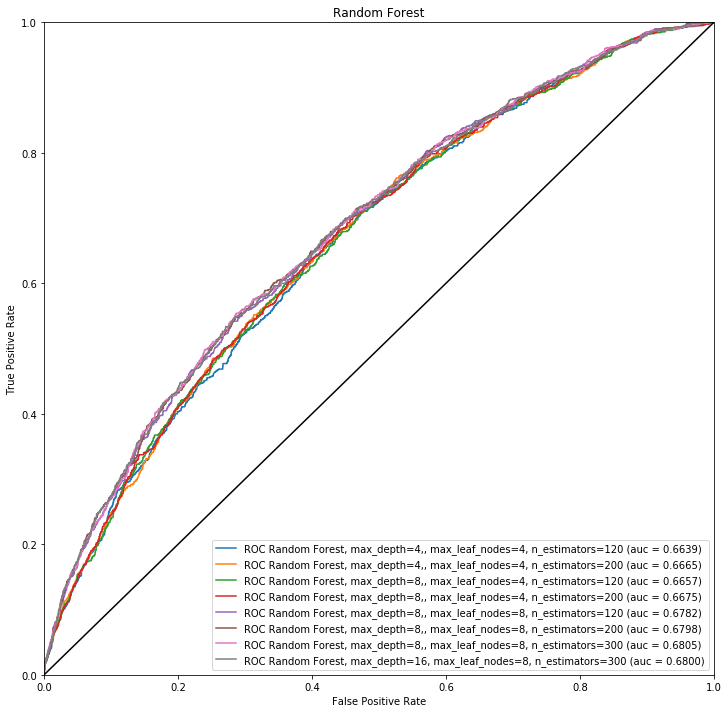

In [20]:
# На графике можно видеть семейство кривых ROC, по X-координате отложен
# False Positive Rate (т.е. относительно как часто модель ошибалась, предсказав что кредит будет возвращен, когда на самом деле
# он не был возвращен), на Y-координате True Positive Rate - т.е. относительно как часто модель была права, когда предсказывала
# что кредит будет возвращен
# Т.е. чем больше площадь под кривой, тем лучше модель класифицирует клиентов
# Среди протестированных гиперпараметров, лучше всего показала модель с n_estimators=300, max_depth=8, max_leaf_nodes=8
# Интересно, что более сложная модель (max_depth_16) показала себя хуже. Здесь корее всего из-за большей глубины выращивания
# дерева, имеет место переобучение, соответственно на тестовом сете результаты оказались хуже
plt.figure(figsize=(12,12))
for result in results:
    str_model = result['model']
    pl.plot(result['fpr'], result['tpr'], label='ROC Random Forest, %s, %s, %s (auc = %0.4f)'
            % (str_model[str_model.find('max_depth='):str_model.find('max_depth=') + 12],
               str_model[str_model.find('max_leaf_nodes='):str_model.find('max_leaf_nodes=') + 16],
               str_model[str_model.find('n_estimators='):str_model.find('n_estimators=') + 16],
               result['roc_auc']))
pl.plot([0, 1], [0, 1], '-', color=(0, 0, 0))
pl.xlim([0, 1])
pl.ylim([0, 1])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Random Forest')
pl.legend(loc="lower right")
pl.show()

# Gradient Boosting
Один из самых популярных алгоритмов, сравним на сколько он лучше случайного леса

In [21]:
gboost_100_4_01 = GradientBoostingClassifier(n_estimators=100, max_depth=4, learning_rate=0.1)
gboost_200_4_01 = GradientBoostingClassifier(n_estimators=200, max_depth=4, learning_rate=0.1)
gboost_100_8_01 = GradientBoostingClassifier(n_estimators=100, max_depth=8, learning_rate=0.1)
gboost_200_8_01 = GradientBoostingClassifier(n_estimators=200, max_depth=8, learning_rate=0.1)
gboost_100_4_05 = GradientBoostingClassifier(n_estimators=100, max_depth=4, learning_rate=0.5)
gboost_200_4_05 = GradientBoostingClassifier(n_estimators=100, max_depth=4, learning_rate=0.5)

In [22]:
models_gb = [gboost_100_4_01, gboost_200_4_01, gboost_100_8_01, gboost_200_8_01, gboost_100_4_05, gboost_200_4_05]
results_gb = []
for model in models_gb:
    model.fit(train_data, train_target)
    predict = model.predict_proba(val_data)[:,1]
    fpr, tpr, thresholds = roc_curve(val_target, predict)
    roc_auc = roc_auc_score(val_target, predict)
    results_gb.append({'model': str(model), 'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc})

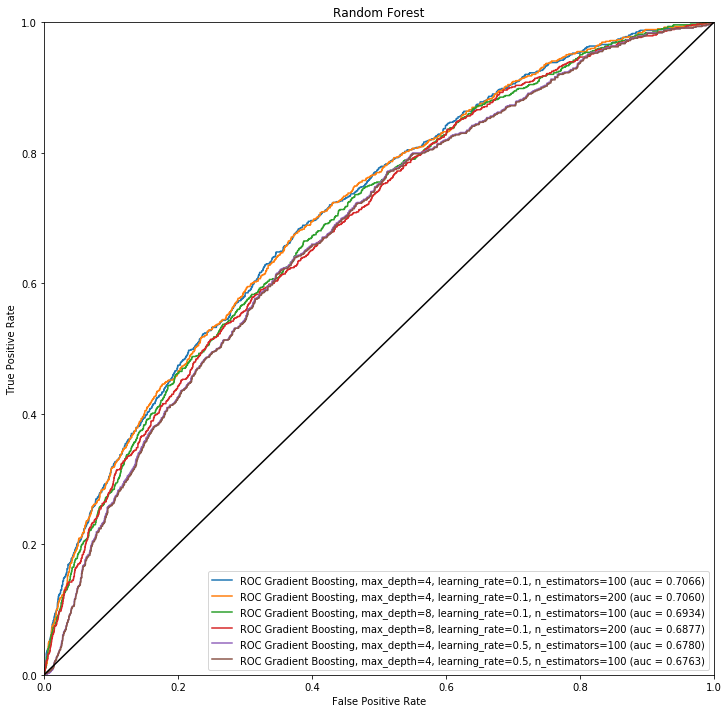

In [24]:
# Градиентный бустинг показал лучшие результаты (0.706). При прошлом запуске, цифра доходила до 0.73, а значит 
# стоит потестировать гиперпараметры и изначальную инициализацию
plt.figure(figsize=(12,12))
for result in results_gb:
    str_model = result['model']
    pl.plot(result['fpr'], result['tpr'], label='ROC Gradient Boosting, %s, %s, %s (auc = %0.4f)'
            % (str_model[str_model.find('max_depth='):str_model.find('max_depth=') + 11],
               str_model[str_model.find('learning_rate='):str_model.find('learning_rate=') + 17],
               str_model[str_model.find('n_estimators='):str_model.find('n_estimators=') + 16],
               result['roc_auc']))
pl.plot([0, 1], [0, 1], '-', color=(0, 0, 0))
pl.xlim([0, 1])
pl.ylim([0, 1])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Random Forest')
pl.legend(loc="lower right")
pl.show()

# MLP (Keras)
Попробуем решить задачу с помощью простых сетей (Multy Layer Perceptron). Будем использовать фраемворк Keras с бекендом tensorflow


In [26]:
# Для сетей (в отличии от прошлых алгоритмов), очень важно нормализовать все входящие данные.
# Используем для этого еще один трансформер sklearn, Normalizer
norm = Normalizer()
norm.fit(train_pca)        # Используем .fit на датасете, полученным после PCA, т.к. нормировать будем данные по всему датасету                
train_data_k = norm.transform(train_data)
val_data_k = norm.transform(val_data)

In [28]:
# здесь большой простор для тестов гиперпараметров, начиная от размера батчей, и заканчивая самой архитектурой сети
batch_size = 512
epochs = 1400 # кол-во епох обучения, для теста взял небольшую цифру

train_target_k = train_target.astype('float32')
val_target_k = val_target.astype('float32')

# Модель будет состоять из 4 слоев: 1 - скрытый слой с 128 нейронами, 2 - аналогично с 64 нейронами, 3 - с 32 нейронами
# последний слой - выходной, содержит только 1 нейрон (закроет или не закроет кредит)
# Во всех слоях можно поэкспериментировать с активациями, но я взял самый простой вид - сигмоида, на выходе тоже оставляем
# ее, т.к. нам нужна цифра от 0 до 1
model = Sequential()
model.add(Dense(128, activation='sigmoid', input_dim=30))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(train_data_k, train_target_k,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)
score = model.evaluate(val_data_k, val_target_k, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               3968      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 14,337
Trainable params: 14,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1400
28024/28024 [==============================] - 0s 14us/step - loss: 0.4167 - acc: 0.8629
Epoch 2/1400
28024/28024 [==============================] - 0s 6us/step - loss: 0.3745 - acc: 0.8762
Epoch 3/1400
28024/28024 [==============================] - 0s 6us/

28024/28024 [==============================] - 0s 5us/step - loss: 0.3685 - acc: 0.8762
Epoch 73/1400
28024/28024 [==============================] - 0s 4us/step - loss: 0.3686 - acc: 0.8762
Epoch 74/1400
28024/28024 [==============================] - 0s 4us/step - loss: 0.3689 - acc: 0.8762
Epoch 75/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3684 - acc: 0.8762
Epoch 76/1400
28024/28024 [==============================] - 0s 4us/step - loss: 0.3687 - acc: 0.8762
Epoch 77/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3687 - acc: 0.8762
Epoch 78/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3685 - acc: 0.8762
Epoch 79/1400
28024/28024 [==============================] - 0s 4us/step - loss: 0.3686 - acc: 0.8762
Epoch 80/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3685 - acc: 0.8762
Epoch 81/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3685 - acc: 0

28024/28024 [==============================] - 0s 5us/step - loss: 0.3680 - acc: 0.8762
Epoch 152/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3679 - acc: 0.8762
Epoch 153/1400
28024/28024 [==============================] - 0s 4us/step - loss: 0.3679 - acc: 0.8762
Epoch 154/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3680 - acc: 0.8762
Epoch 155/1400
28024/28024 [==============================] - 0s 4us/step - loss: 0.3680 - acc: 0.8762
Epoch 156/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3680 - acc: 0.8762
Epoch 157/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3681 - acc: 0.8762
Epoch 158/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3680 - acc: 0.8762
Epoch 159/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3681 - acc: 0.8762
Epoch 160/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3679

28024/28024 [==============================] - 0s 5us/step - loss: 0.3663 - acc: 0.8762
Epoch 230/1400
28024/28024 [==============================] - 0s 6us/step - loss: 0.3664 - acc: 0.8762
Epoch 231/1400
28024/28024 [==============================] - 0s 6us/step - loss: 0.3665 - acc: 0.8762
Epoch 232/1400
28024/28024 [==============================] - 0s 4us/step - loss: 0.3663 - acc: 0.8762
Epoch 233/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3663 - acc: 0.8762
Epoch 234/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3663 - acc: 0.8762
Epoch 235/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3663 - acc: 0.8762
Epoch 236/1400
28024/28024 [==============================] - 0s 4us/step - loss: 0.3664 - acc: 0.8762
Epoch 237/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3663 - acc: 0.8762
Epoch 238/1400
28024/28024 [==============================] - 0s 4us/step - loss: 0.3662

28024/28024 [==============================] - 0s 5us/step - loss: 0.3654 - acc: 0.8762
Epoch 309/1400
28024/28024 [==============================] - 0s 6us/step - loss: 0.3652 - acc: 0.8762
Epoch 310/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3651 - acc: 0.8762
Epoch 311/1400
28024/28024 [==============================] - 0s 4us/step - loss: 0.3651 - acc: 0.8762
Epoch 312/1400
28024/28024 [==============================] - 0s 4us/step - loss: 0.3651 - acc: 0.8762
Epoch 313/1400
28024/28024 [==============================] - 0s 6us/step - loss: 0.3651 - acc: 0.8762
Epoch 314/1400
28024/28024 [==============================] - 0s 6us/step - loss: 0.3651 - acc: 0.8762
Epoch 315/1400
28024/28024 [==============================] - 0s 6us/step - loss: 0.3650 - acc: 0.8762
Epoch 316/1400
28024/28024 [==============================] - 0s 6us/step - loss: 0.3652 - acc: 0.8762
Epoch 317/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3650

28024/28024 [==============================] - 0s 6us/step - loss: 0.3650 - acc: 0.8762
Epoch 388/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3650 - acc: 0.8762
Epoch 389/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3649 - acc: 0.8762
Epoch 390/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3645 - acc: 0.8762
Epoch 391/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3647 - acc: 0.8762
Epoch 392/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3647 - acc: 0.8762
Epoch 393/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3645 - acc: 0.8762
Epoch 394/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3648 - acc: 0.8762
Epoch 395/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3647 - acc: 0.8762
Epoch 396/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3646

28024/28024 [==============================] - 0s 5us/step - loss: 0.3643 - acc: 0.8762
Epoch 467/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3644 - acc: 0.8762
Epoch 468/1400
28024/28024 [==============================] - 0s 4us/step - loss: 0.3644 - acc: 0.8762
Epoch 469/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3645 - acc: 0.8762
Epoch 470/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3642 - acc: 0.8762
Epoch 471/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3645 - acc: 0.8762
Epoch 472/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3643 - acc: 0.8762
Epoch 473/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3642 - acc: 0.8762
Epoch 474/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3642 - acc: 0.8762
Epoch 475/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3643

28024/28024 [==============================] - 0s 5us/step - loss: 0.3641 - acc: 0.8762
Epoch 546/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3639 - acc: 0.8762
Epoch 547/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3641 - acc: 0.8762
Epoch 548/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3638 - acc: 0.8762
Epoch 549/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3638 - acc: 0.8762
Epoch 550/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3639 - acc: 0.8762
Epoch 551/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3640 - acc: 0.8762
Epoch 552/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3640 - acc: 0.8762
Epoch 553/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3638 - acc: 0.8762
Epoch 554/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3639

28024/28024 [==============================] - 0s 5us/step - loss: 0.3635 - acc: 0.8762
Epoch 625/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3636 - acc: 0.8762
Epoch 626/1400
28024/28024 [==============================] - 0s 4us/step - loss: 0.3637 - acc: 0.8762
Epoch 627/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3637 - acc: 0.8762
Epoch 628/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3639 - acc: 0.8762
Epoch 629/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3639 - acc: 0.8762
Epoch 630/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3638 - acc: 0.8762
Epoch 631/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3637 - acc: 0.8762
Epoch 632/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3636 - acc: 0.8762
Epoch 633/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3637

28024/28024 [==============================] - 0s 5us/step - loss: 0.3635 - acc: 0.8762
Epoch 704/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3635 - acc: 0.8762
Epoch 705/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3634 - acc: 0.8762
Epoch 706/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3634 - acc: 0.8762
Epoch 707/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3635 - acc: 0.8762
Epoch 708/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3637 - acc: 0.8762
Epoch 709/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3638 - acc: 0.8762
Epoch 710/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3635 - acc: 0.8762
Epoch 711/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3633 - acc: 0.8762
Epoch 712/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3639

28024/28024 [==============================] - 0s 5us/step - loss: 0.3631 - acc: 0.8763
Epoch 783/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3632 - acc: 0.8763
Epoch 784/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3634 - acc: 0.8762
Epoch 785/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3633 - acc: 0.8763
Epoch 786/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3633 - acc: 0.8763
Epoch 787/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3634 - acc: 0.8763
Epoch 788/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3633 - acc: 0.8762
Epoch 789/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3636 - acc: 0.8763
Epoch 790/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3633 - acc: 0.8763
Epoch 791/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3632

28024/28024 [==============================] - 0s 5us/step - loss: 0.3630 - acc: 0.8763
Epoch 862/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3630 - acc: 0.8763
Epoch 863/1400
28024/28024 [==============================] - 0s 4us/step - loss: 0.3631 - acc: 0.8763
Epoch 864/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3630 - acc: 0.8763
Epoch 865/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3631 - acc: 0.8763
Epoch 866/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3630 - acc: 0.8763
Epoch 867/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3632 - acc: 0.8763
Epoch 868/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3630 - acc: 0.8763
Epoch 869/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3629 - acc: 0.8763
Epoch 870/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3631

28024/28024 [==============================] - 0s 5us/step - loss: 0.3629 - acc: 0.8763
Epoch 941/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3628 - acc: 0.8763
Epoch 942/1400
28024/28024 [==============================] - 0s 4us/step - loss: 0.3629 - acc: 0.8763
Epoch 943/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3631 - acc: 0.8763
Epoch 944/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3631 - acc: 0.8763
Epoch 945/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3628 - acc: 0.8763
Epoch 946/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3627 - acc: 0.8763
Epoch 947/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3631 - acc: 0.8763
Epoch 948/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3629 - acc: 0.8763
Epoch 949/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3627

28024/28024 [==============================] - 0s 5us/step - loss: 0.3625 - acc: 0.8764
Epoch 1020/1400
28024/28024 [==============================] - 0s 4us/step - loss: 0.3627 - acc: 0.8764
Epoch 1021/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3626 - acc: 0.8763
Epoch 1022/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3627 - acc: 0.8764
Epoch 1023/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3628 - acc: 0.8763
Epoch 1024/1400
28024/28024 [==============================] - ETA: 0s - loss: 0.3595 - acc: 0.877 - 0s 5us/step - loss: 0.3625 - acc: 0.8764
Epoch 1025/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3627 - acc: 0.8763
Epoch 1026/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3626 - acc: 0.8764
Epoch 1027/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3626 - acc: 0.8764
Epoch 1028/1400
28024/28024 [=============

28024/28024 [==============================] - 0s 5us/step - loss: 0.3623 - acc: 0.8764
Epoch 1098/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3628 - acc: 0.8764
Epoch 1099/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3624 - acc: 0.8764
Epoch 1100/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3623 - acc: 0.8764
Epoch 1101/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3624 - acc: 0.8764
Epoch 1102/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3625 - acc: 0.8764
Epoch 1103/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3624 - acc: 0.8764
Epoch 1104/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3630 - acc: 0.8764
Epoch 1105/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3626 - acc: 0.8764
Epoch 1106/1400
28024/28024 [==============================] - 0s 5us/step - los

28024/28024 [==============================] - 0s 5us/step - loss: 0.3622 - acc: 0.8764
Epoch 1176/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3620 - acc: 0.8764
Epoch 1177/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3623 - acc: 0.8764
Epoch 1178/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3624 - acc: 0.8764
Epoch 1179/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3620 - acc: 0.8764
Epoch 1180/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3619 - acc: 0.8764
Epoch 1181/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3622 - acc: 0.8764
Epoch 1182/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3621 - acc: 0.8764
Epoch 1183/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3622 - acc: 0.8764
Epoch 1184/1400
28024/28024 [==============================] - 0s 5us/step - los

28024/28024 [==============================] - 0s 5us/step - loss: 0.3619 - acc: 0.8764
Epoch 1254/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3617 - acc: 0.8764
Epoch 1255/1400
28024/28024 [==============================] - 0s 6us/step - loss: 0.3617 - acc: 0.8764
Epoch 1256/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3620 - acc: 0.8764
Epoch 1257/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3620 - acc: 0.8764
Epoch 1258/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3619 - acc: 0.8764
Epoch 1259/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3617 - acc: 0.8764
Epoch 1260/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3618 - acc: 0.8764
Epoch 1261/1400
28024/28024 [==============================] - 0s 4us/step - loss: 0.3617 - acc: 0.8764
Epoch 1262/1400
28024/28024 [==============================] - 0s 5us/step - los

28024/28024 [==============================] - 0s 5us/step - loss: 0.3614 - acc: 0.8764
Epoch 1332/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3616 - acc: 0.8764
Epoch 1333/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3614 - acc: 0.8764
Epoch 1334/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3618 - acc: 0.8764
Epoch 1335/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3613 - acc: 0.8764
Epoch 1336/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3616 - acc: 0.8764
Epoch 1337/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3619 - acc: 0.8764
Epoch 1338/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3616 - acc: 0.8765
Epoch 1339/1400
28024/28024 [==============================] - 0s 5us/step - loss: 0.3614 - acc: 0.8764
Epoch 1340/1400
28024/28024 [==============================] - 0s 5us/step - los

In [29]:
predict = model.predict(val_data_k)
fpr, tpr, thresholds = roc_curve(val_target_k, predict)
roc_auc = roc_auc_score(val_target_k, predict)

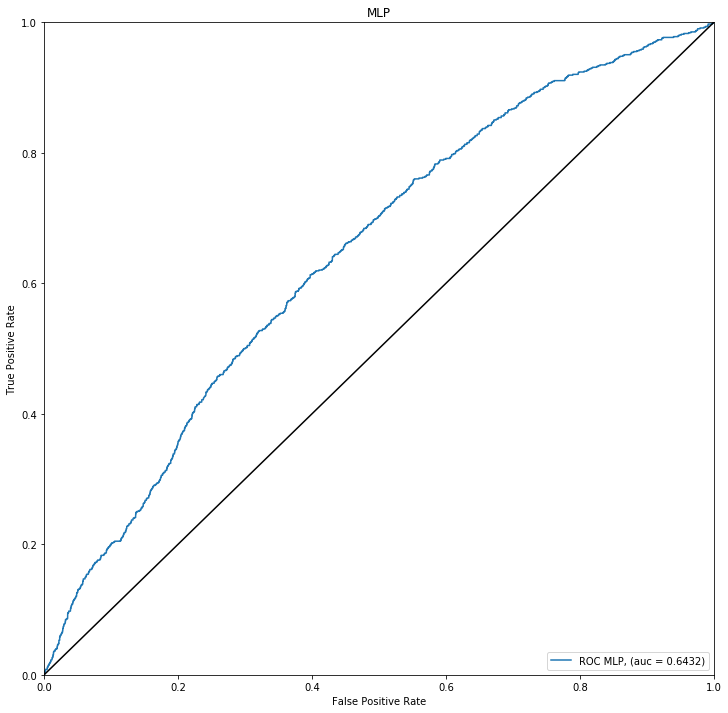

In [37]:
# Результат хуже предыдущих алгоритмов. Однако это на первый взгляд, на самом деле эксперименты с гиперпараметрами
# улучшат результат, к тому же я использовал небольшое кол-во эпох обучения
plt.figure(figsize=(12,12))
pl.plot(fpr, tpr, label='ROC MLP, (auc = %0.4f)' % (roc_auc))
pl.plot([0, 1], [0, 1], '-', color=(0, 0, 0))
pl.xlim([0, 1])
pl.ylim([0, 1])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('MLP')
pl.legend(loc="lower right")
pl.show()

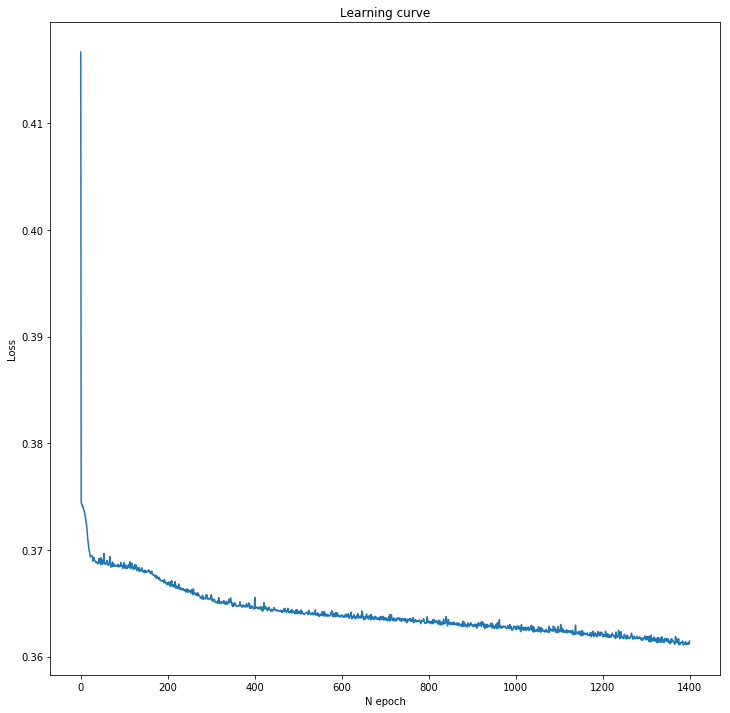

In [39]:
# Можем посмотреть на ошибку обучения по эпохам
# Модель явно не вышла на асимптоту ошибки, а значит повысив кол-во эпох можно добиться лучших результатов
plt.figure(figsize=(12,12))
pl.plot(history.epoch, history.history['loss'])
pl.xlabel('N epoch')
pl.ylabel('Loss')
pl.title('Learning curve')
plt.show()

## Выводы
Мы получили неплохие результаты скоринга кредитов, однако чтобы понять на сколько они хороши, нужно сверять с уровнем ошибки человека, т.е. сколько клиентов не вернет кредит среди одобренных кредитов менеджером.  
Сами модели тоже можно улучшить следующими вариантами:
1. Экспериментами с гиперпараметрами (могут сильно увеличить точность), однако надо помнить, что усложняя модель, мы рискуем переобучить ее. Проверить это можно кросс-валидацией
2. Работа с данными. Можно повысить число метрик, оставляемых после PCA, поискать зависимости между данными (возможно добавить новые фичи)
3. Поэкспериментировать с алгоритмами. К примеру: мы группировали данные по клиентам, суммируя все числовые показатели. Однако можно уйти от этого (т.к. мы теряем часть информации), к примеру подавая все уникальные выписки из кредитных бюро на вход реккурентной сети (Seq2One). Т.е. тестируя новые алгоритмы, можно найти лучшее решение
4. Мы не знаем, когда собирался датасет, и возможно более точные курсы валют могли бы повысить или понизить веса величины кредита, тем самым давая дополнительную точность.

Пока же после небольших опытом мне удалось достичь максимум 73% используя градиентный бустинг.